# 復習　ローカルレベルモデル(9.2)

$x_t = x_{t-1} + w_t, w_t \sim N(0,W)$ 

$y_t = x_t + v_t, v_t \sim N(0, V)$

$x_0 \sim N(m_0, C_0) $

- これから用いる人工的なローカルレベルは、

$W=1, V=2, m_0 = 10, C_0 = 9$

としている。

# 復習　10.3.2 パラメータが既知の場合のMCMC

```
// model10-1.stan
// モデル：規定【ローカルレベルモデル、パラメータが既知】

data{
  int<lower=1>   t_max;    // 時系列長
  vector[t_max]   y;       // 観測値

  cov_matrix[1]   W;       // 状態雑音の分散
  cov_matrix[1]   V;       // 観測雑音の分散
  real           m0;       // 事前分布の平均
  cov_matrix[1]  C0;       // 事前分布の分散
}

parameters{
  real           x0;       // 状態[0]
  vector[t_max]   x;       // 状態[1:t_max]
}

model{
  // 尤度の部分
  /* 観測方程式・・・(5.11)式を参照 */
  for (t in 1:t_max){
    y[t] ~ normal(x[t], sqrt(V[1, 1]));
  }

  // 事前分布の部分
  /* 状態の事前分布 */
  x0   ~ normal(m0, sqrt(C0[1, 1]));

  /* 状態方程式・・・(5.10)式を参照 */
  x[1] ~ normal(x0, sqrt(W[1, 1]));
  for (t in 2:t_max){
    x[t] ~ normal(x[t-1], sqrt(W[1, 1]));
  }
}

```

- data ブロック・・・R側から渡される定数
- paramters ブロック・・・サンプリング対象の変数
- model ブロック・・・事後分布に関する記述

In [1]:
#【MCMCを活用したローカルレベルモデルの平滑化（パラメータが既知）】

# 前処理
set.seed(123)
library(rstan)

# Stanの事前設定：コードのHDD保存、並列演算、グラフの縦横比
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
theme_set(theme_get() + theme(aspect.ratio = 3/4))

# 人工的なローカルレベルモデルに関するデータを読み込み
load(file = "ArtifitialLocalLevelModel.RData")

 要求されたパッケージ StanHeaders をロード中です 

 要求されたパッケージ ggplot2 をロード中です 

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



In [2]:
# モデル：生成・コンパイル
stan_mod_out <- stan_model(file = "model10-1.stan")

In [3]:
# 平滑化：実行（サンプリング）
fit_stan <- sampling(object = stan_mod_out,
                     data = list(t_max = t_max, y = y, 
                                 W = mod$W, V = mod$V, 
                                 m0 = mod$m0, C0 = mod$C0),
                     pars = c("x"),
                     seed = 123
            )

Inference for Stan model: model10-1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
x[1]     11.77    0.01 0.93    9.97   11.16   11.78   12.40   13.58  4846    1
x[2]     12.84    0.01 0.85   11.17   12.27   12.86   13.41   14.49  4659    1
x[3]     13.28    0.01 0.83   11.65   12.72   13.27   13.84   14.92  4792    1
x[4]     13.30    0.01 0.83   11.68   12.73   13.29   13.85   14.94  5371    1
x[5]     13.14    0.01 0.82   11.53   12.58   13.15   13.71   14.69  5230    1
x[6]     12.30    0.01 0.84   10.68   11.74   12.31   12.87   13.94  4943    1
x[7]     12.12    0.01 0.81   10.49   11.58   12.13   12.69   13.67  4742    1
x[8]     11.51    0.01 0.82    9.94   10.95   11.49   12.05   13.13  4634    1
x[9]     10.94    0.01 0.83    9.29   10.39   10.95   11.49   12.56  4908    1
x[10]    10.95    0.01 0.82    9.40   10.42   10.94   1

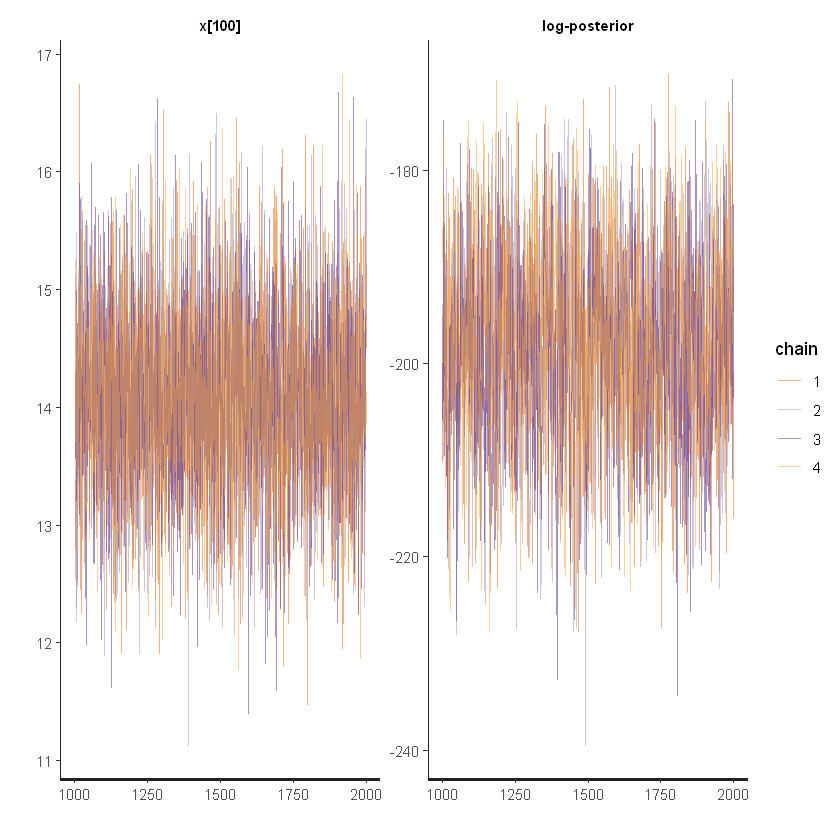

In [4]:
# 結果の確認
oldpar <- par(no.readonly = TRUE); options(max.print = 99999)
fit_stan
options(oldpar)
traceplot(fit_stan, pars = c(sprintf("x[%d]", 100), "lp__"), alpha = 0.5)

List of 1
 $ x: num [1:4000, 1:200] 11.4 12.3 11 11.6 12.8 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ iterations: NULL
  .. ..$           : NULL


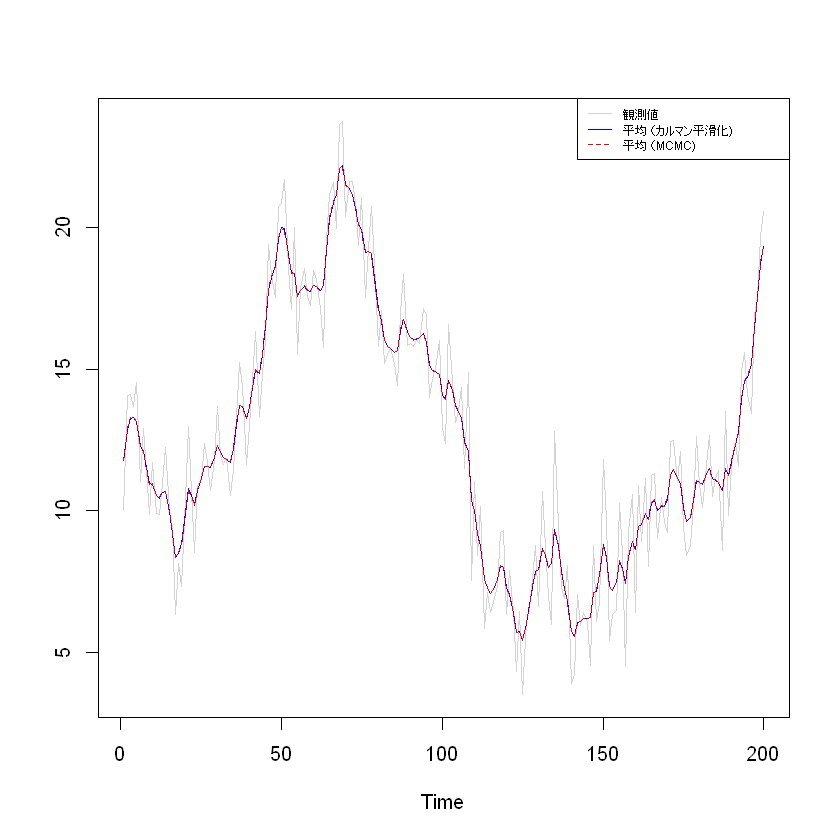

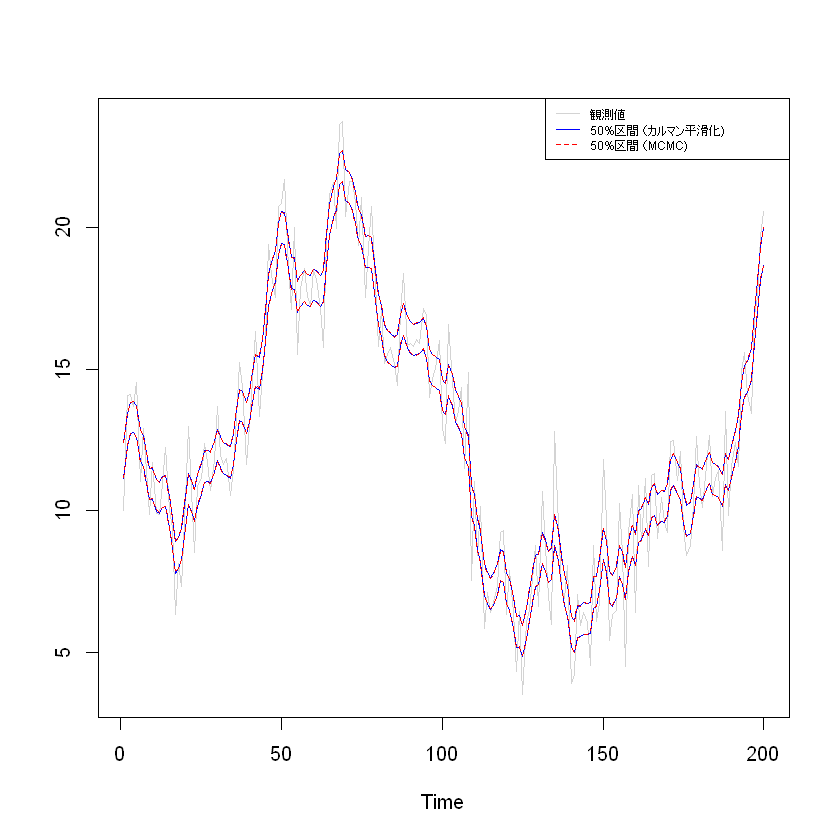

In [5]:
# 必要なサンプリング結果を取り出す
stan_mcmc_out <- rstan::extract(fit_stan, pars = "x")
str(stan_mcmc_out)

# 周辺化を行い、平均・25%値・75%値を求める
s_mcmc <- colMeans(stan_mcmc_out$x)
s_mcmc_quant <- apply(stan_mcmc_out$x, 2, FUN = quantile, probs=c(0.25, 0.75))

# 結果のプロット
ts.plot(cbind(y, s), col = c("lightgray", "blue"))
lines(s_mcmc, col = "red", lty = "dashed")

# 凡例
legend(legend = c("観測値", "平均 （カルマン平滑化)",  "平均 （MCMC)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 50, cex = 0.6)

# 結果のプロット
ts.plot(cbind(y, do.call("cbind", s_quant)),
        col = c("lightgray", "blue", "blue"))
lines(s_mcmc_quant["25%", ], col = "red", lty = "dashed")
lines(s_mcmc_quant["75%", ], col = "red", lty = "dashed")

# 凡例
legend(legend = c("観測値", "50%区間 （カルマン平滑化)",  "50%区間 （MCMC)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 60, cex = 0.6)

```
// model10-2.stan
// モデル：規定【ローカルレベルモデル、パラメータが未知】

data{
  int<lower=1>   t_max;    // 時系列長
  vector[t_max]   y;       // 観測値

  real           m0;       // 事前分布の平均
  cov_matrix[1]  C0;       // 事前分布の分散
}

parameters{
  real           x0;       // 状態[0]
  vector[t_max]   x;       // 状態[1:t_max]

  cov_matrix[1]   W;       // 状態雑音の分散   <- !!!!!!!!!
  cov_matrix[1]   V;       // 観測雑音の分散   <- !!!!!!!!!
}

model{
  // 尤度の部分
  /* 観測方程式 */
  for (t in 1:t_max){
    y[t] ~ normal(x[t], sqrt(V[1, 1]));
  }

  // 事前分布の部分
  /* 状態の事前分布 */
  x0   ~ normal(m0, sqrt(C0[1, 1]));

  /* 状態方程式 */
  x[1] ~ normal(x0, sqrt(W[1, 1]));
  for (t in 2:t_max){
    x[t] ~ normal(x[t-1], sqrt(W[1, 1]));
  }

  /* W, Vの事前分布：無情報事前分布（省略時のデフォルト設定を活用） */
}

```

In [6]:
#【MCMCを活用したローカルレベルモデルの平滑化（パラメータが未知）】

# 前処理
set.seed(123)
library(rstan)

# Stanの事前設定：コードのHDD保存、並列演算、グラフの縦横比
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
theme_set(theme_get() + theme(aspect.ratio = 3/4))

# 人工的なローカルレベルモデルに関するデータを読み込み
load(file = "ArtifitialLocalLevelModel.RData")

# モデル：生成・コンパイル
stan_mod_out <- stan_model(file = "model10-2.stan")

In [7]:
# 平滑化：実行（サンプリング）
fit_stan <- sampling(object = stan_mod_out,
                     data = list(t_max = t_max, y = y, 
                                 m0 = mod$m0, C0 = mod$C0),
                     pars = c("W", "V", "x"),
                     seed = 123
            )

In [8]:
# 結果の確認
oldpar <- par(no.readonly = TRUE); options(max.print = 99999)
fit_stan

Inference for Stan model: model10-2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean    sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
W[1,1]    0.99    0.01  0.26    0.57    0.80    0.96    1.13    1.60   646 1.00
V[1,1]    2.07    0.01  0.32    1.49    1.85    2.06    2.26    2.73  1802 1.00
x[1]     11.83    0.02  0.94   10.02   11.23   11.83   12.46   13.65  3778 1.00
x[2]     12.82    0.01  0.86   11.11   12.26   12.83   13.41   14.47  4603 1.00
x[3]     13.25    0.01  0.85   11.60   12.68   13.25   13.81   14.90  4118 1.00
x[4]     13.27    0.01  0.84   11.59   12.70   13.29   13.82   14.97  4242 1.00
x[5]     13.12    0.01  0.84   11.51   12.55   13.12   13.68   14.81  4171 1.00
x[6]     12.31    0.01  0.82   10.68   11.75   12.31   12.85   13.93  5390 1.00
x[7]     12.11    0.01  0.82   10.49   11.56   12.10   12.66   13.68  4263 1.00
x[8]     11.52    0.01  0.82    9.91   10.97 

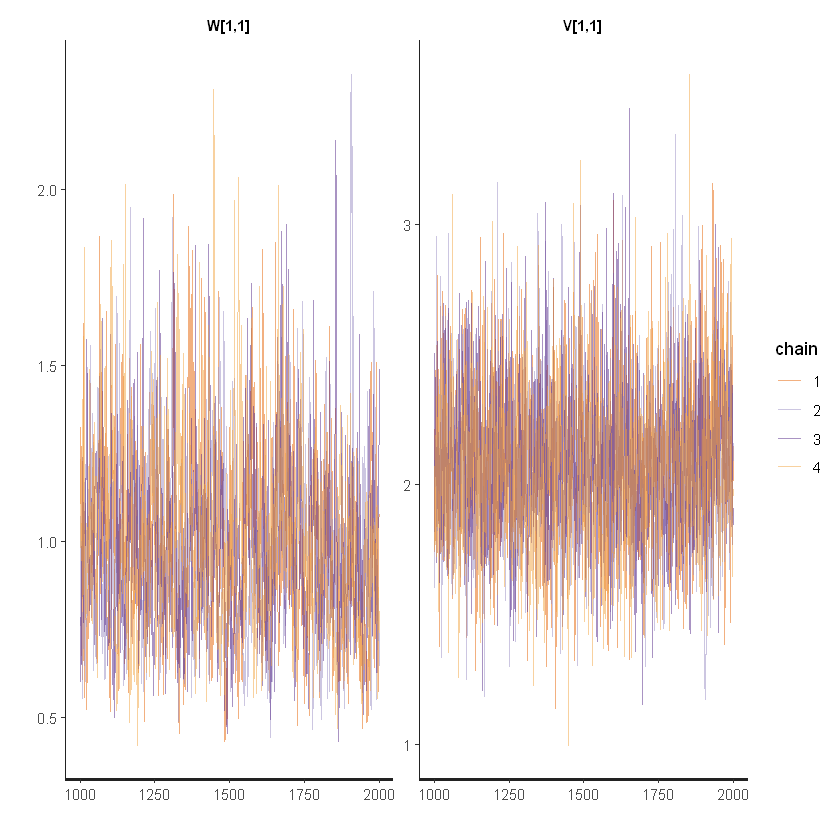

In [9]:
# 以降のコードは表示を省略

options(oldpar)
traceplot(fit_stan, pars = c("W", "V"), alpha = 0.5)

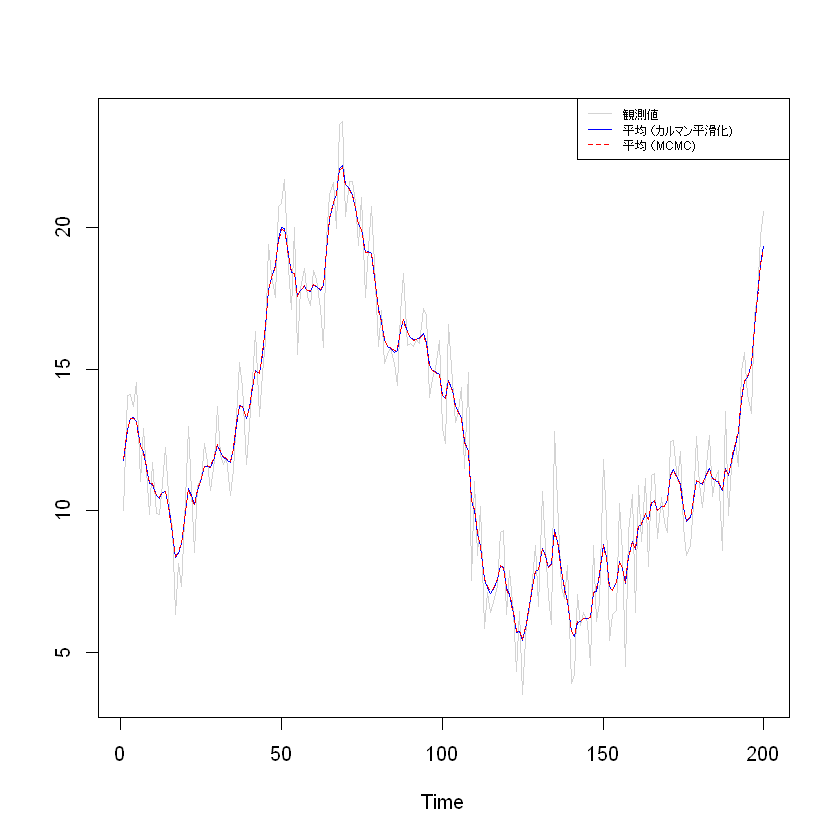

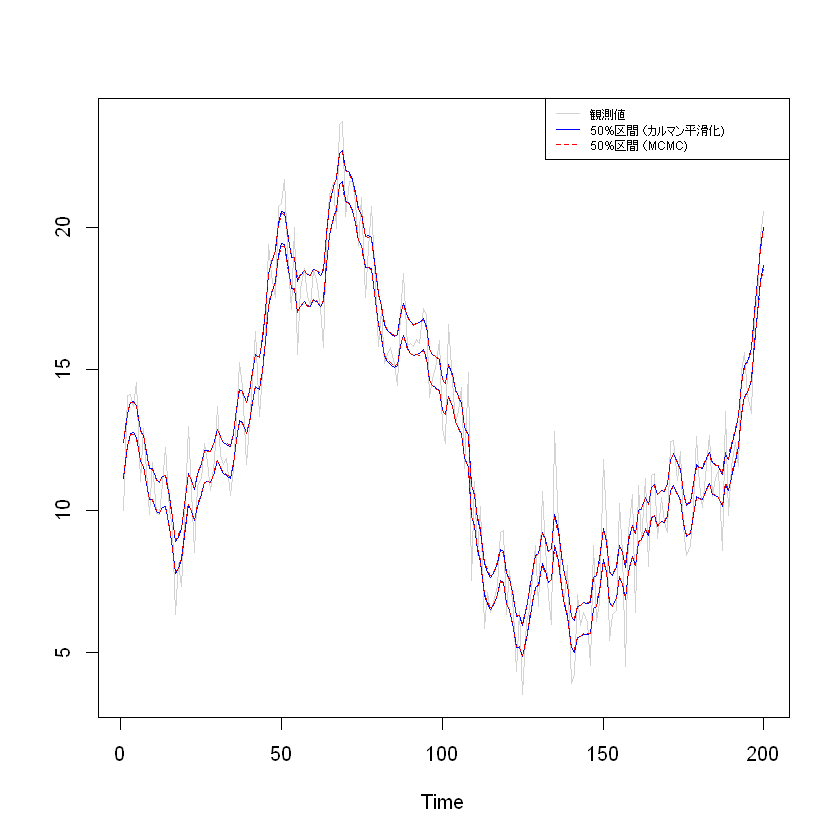

In [10]:
# 必要なサンプリング結果を取り出す
stan_mcmc_out <- rstan::extract(fit_stan, pars = "x")

# 周辺化を行い、平均・25%値・75%値を求める
s_mcmc <- colMeans(stan_mcmc_out$x)
s_mcmc_quant <- apply(stan_mcmc_out$x, 2, FUN = quantile, probs=c(0.25, 0.75))

# 結果のプロット
ts.plot(cbind(y, s), col = c("lightgray", "blue"))
lines(s_mcmc, col = "red", lty = "dashed")

# 凡例
legend(legend = c("観測値", "平均 （カルマン平滑化)",  "平均 （MCMC)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 50, cex = 0.6)

# 結果のプロット
ts.plot(cbind(y, do.call("cbind", s_quant)),
        col = c("lightgray", "blue", "blue"))
lines(s_mcmc_quant["25%", ], col = "red", lty = "dashed")
lines(s_mcmc_quant["75%", ], col = "red", lty = "dashed")

# 凡例
legend(legend = c("観測値", "50%区間 （カルマン平滑化)",  "50%区間 （MCMC)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 60, cex = 0.6)